# Schematized model of the Waal River

## Purpose 

In this exercise, we consider a 90 km long stretch of the River Waal. The River Waal is the main branch of the Rhine in the Netherlands and runs from the bifurcation of Pannerden to the bifurcation at Werkendam (see image below).

<img src="./figures/river_waal.png" alt="Drawing" style="float: left" style="width: 800px;"/> 

Figure 1: The waal stretch from Pannerden to Werkendam.

To perform a quantitative analysis, we consider the stretch as if it were a straight flume, with constant bed slope and width. Depending on the flow discharge, the bed roughness and the downstream water level boundary condition, different flow regimes can occur. The simplest form - which can also be computed analytically - is a uniform channel flow situation, where a constant (equilibrium) water depth $H^{eq}$ and a constant flow velocity $u$ develop along the full length of the model.

A different flow situation can occur when the discharge is higher/lower than the equilibrium discharge (belonging to the equilibrium depth $H^{eq}$. A steady example of such a flow situation is a backwater/Bélanger curve and a dynamic case is a river flood wave. 

## Aim

The aim of this exercise is twofold. First, we inspect whether a 1D numerical model (with many assumptions!) can represent the analytical solution of uniform channel flow. This can be done for different combinations of boundary conditions and the bottom friction coefficient. Second, we will see that if the boundary conditions (together with the bottom friction coefficient) do not correspond to the situation of uniform channel flow, a backwater or Bélanger curve will develop.

## Approach

First we set up the model to compute uniform channel flow. Our river stretch is a simplified version of the Waal River in the Netherlands, from the city of Pannerden to the city of Werkendam (see Figure 1). The river/channel has the following dimensions:

Length $L$ = 90 km <br>
Width $B$ = 250 m <br>
Bed slope $i_b$ = 1e-4 m/m (positive downwards)

Additionally, we prescribe a steady discharge $Q$ = 1000 m$^3$/s and a Chézy value of $C$ = 50 m$^{1/2}$/s. Chézy is a another way to represent roughness $(C = \sqrt{g/c_f})$. Using the Chézy formula we can now compute the equilibrium depth that should theoretically develop for these channel/flow characteristics:

$u = C \sqrt{R i_b}$ , or <br>
$u = C \sqrt{H^{eq} i_b}$ .

where we assumed the hydraulic radius $R$ ($=$ cross-sectional area/wetted perimeter) is equal to the water depth $H$, which can be considered valid for our wide channel/river section. Now we use $u = Q / (BH)$ and rewrite the equation for the equilibrium depth $H^{eq}$:

$H^{eq} = \left( \frac{Q}{B C \sqrt{i_b}} \right)^{2/3}$ .

Filling in the chosen values for $Q$, $B$, $C$ and $i_b$, one obtains an equilibrium depth $H^{eq}$ = 4 m.
This flow situation is depicted in Figure 2.

<img src="./figures/uniform_channel_flow.png" alt="Drawing" style="float: left" style="width: 800px;"/>
Figure 2: The uniform channel flow situation for the schematic model of the Waal River.

The model grid is one-dimensional, with a grid size $\Delta x$ = 1000m.

## Uniform Flow

Now we can start the exercise. Follow the steps below to inspect the different model states (uniform channel flow, backwater curve) and try different settings for the model parameters.

## Step 1a)

Specify the upstream and downstream water levels, corresponding to the uniform channel flow situation described below. Verify that indeed such a flow situation is reproduced by the model. Do we obtain the correct equilibrium depth $H^{eq}$ = 4 m?

## Step 1b)

Can you think of a reason why prescibing the downstream water level to be exactly the $H^{eq}$ did not suffice?
Hint: The downstream water level boundary is prescribed in the ghost cell which lies just outside the domain ($\Delta x$ = 1000 m)? Does the bed slope at the boundary then influence the required boundary condition? Can you prescribed a different downstream boundary water level, to obtain the equilibrium depth of $H^{eq}$ = 4 m?

At this point you should have obtained a nice uniform channel flow with constant water depth and constant flow velocity. Can you compute the flow velocity? 

## Step 1c)


Can you try a different combination of the discharge $Q$ and the Chézy coefficient $C$, that also gives an equilibrium depth of 4 m?

This concludes the first part of the exercise. The second part will focus on the Bélanger or backwater curves.

## Bélanger or backwater curves

Remember that Bélanger studied the backwater curve. He found that under steady conditions the Saint-Venant equations can be rewritten as 

$\frac{\partial H}{\partial x} = i_b \frac{H^3 - (H^{eq})^3}{H^3 - H_c^3}$.

where $H$ is the water depth, $H^{eq}$ is the equilibrium depth and $H_c = (Q^2/B^2/g)^{1/3}$ is the critical depth. So when you know the downstream water level $H_0$ the upstream water levels can be computed. This can be done numerically, but also analytically as there is in fact an analytical expression which solves the above equation. The full expression can be found in the appendix below.

As it is a rather lengthy equation, you could use the approximation of Bresse. Keep in mind that this is valid for $H \gg H_c$ 

$H(x) = H^{eq} + (H_0-H^{eq}) \frac{1}{2}^\frac{x-x_0}{L_{1/2}} \qquad$   where $L_{1/2} = 0.24\frac{H_e}{i_b}\left(\frac{H_0}{H^{eq}}\right)^{\frac{4}{3}}$.


## Step 1d)

Set the upstream discharge $Q$ to $1000m^3/s$ and the friction $C$ to Chézy = $50 m^{1/2}/s$ (i.e. the original values).
Raise the downstream water level to 5 m. How much will the water level increase at Zaltbommel and Nijmegen due to the 1 m extra water depth at the downstream boundary? Does the Bresse-theory match the model results?

## Step 1e)

Now increase the bottom friction by reducing the Chézy coefficient, for instance by a factor of 2. What do you expect now?

This concludes the exercises for this test case.

In [2]:
# Imports
import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import time

# Something very fishy happening if I don't define a plot first.
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
plt.ioff()
_ = plt.figure()
plt.ion()

# Toggle button for hiding the raw code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [4]:
sys.path.append("d:\checkouts\oss_trunk\src\bin\x64\share\bin")
engine = r'd:\checkouts\oss_trunk\src\bin\x64\dflowfm\bin\dflowfm'
mdufile = r'd:\projects\PAO_cursus\hyd_opp_water_2018\tests\c015_manning_schematic_river\manning_schematic_river.mdu'
wrapper = bmi.wrapper.BMIWrapper(engine=engine);

In [5]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile);
wrapper.initialize();


In [6]:
maxsteps = 100
parameters = [
    {
        "parameter": "zbndz",
        "description": "Boundary Water level Downstream [m]",
        "default": 4
    },    {
        "parameter": "zbndq",
        "description": "Boundary Discharge Upstream [m3/s]",
        "default": 1000
    },    {
        "parameter": "frcu",
        "description": "Roughness Chézy",
        "default": str(wrapper.get_var("frcu")[0])
    }
]

In [7]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=100,
    min=0,
    max=maxsteps,
    style=style,
    layout=Layout(width='15vw')
)

slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

# parameters = ["zbndz", "zbndq", "frcu"]
# p_descrip = ["Boundary Water level", "Boundary Discharge", "Roughness Chézy"]

items=[]
for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))

In [8]:
parameters[0]["default"]

4

In [9]:
# Model specific function 

#     Automate parameter and grid sizes
def update_data():
    waterlevel = wrapper.get_var('s1')[1:-1]
    bedlevel = wrapper.get_var('bl')[1:-1]
    xz = wrapper.get_var('xz')[1:-1]
    data.append(dict({
        "time": float(wrapper.get_current_time()),
        "waterlevel": waterlevel.copy(), 
        "bedlevel": bedlevel.copy(), 
        "xz": xz.copy()
    }))
    slider.max = len(data)
    slider.description="timestep: {}".format(data[slider.value]["time"])
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [10]:
# Standard functions for button widgets
dostop = False
def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
    print(n)
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    for i in items:
        i.disabled = True
    settings.disabled = True
    start_loop(int(nsteps.value))
#         thread = threading.Thread(target=start_loop)
#         thread.start()

def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    for i in items:
        i.disabled = False
    dostop = True

def change_param(v):
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "":
        return
    try:
        float(v.value)
        old_par = wrapper.get_var(v.placeholder)
        new_par = np.ones_like(old_par) * float(v.value)
        wrapper.set_var(v.placeholder, new_par)
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
        settings.value = "Not a correct input for {}".format(v.description)

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(parameters[i]['default'])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


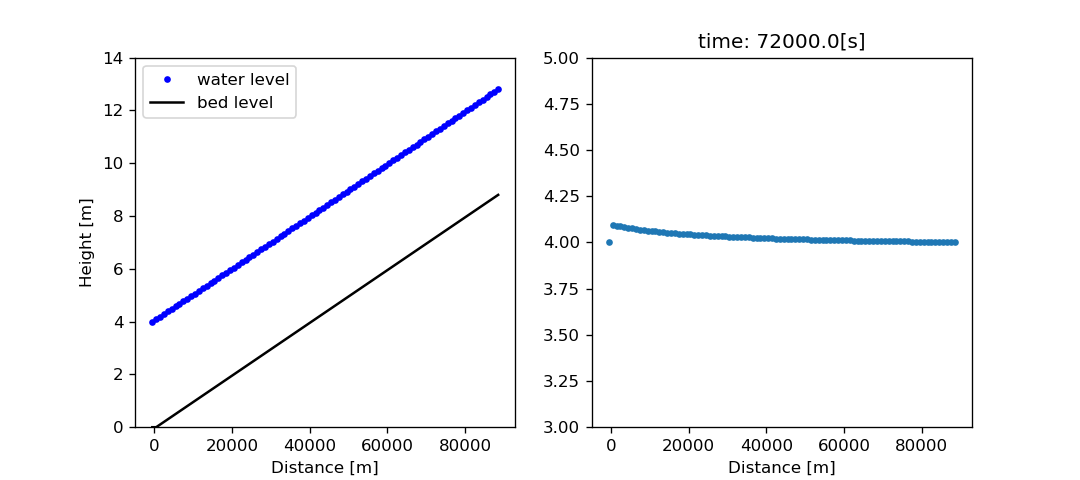

Text(0.5, 0, 'Distance [m]')

100


In [11]:
##### set plot size
plt.rcParams["figure.figsize"] = (9, 4) # (w, h)

# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)

def set_plot(change):
    t = change['new']
    if (t < len(data)):
        wlp.set_data(data[t]["xz"], data[t]["waterlevel"])
        blp.set_data(data[t]["xz"], data[t]["bedlevel"])
        wh.set_data(data[t]["xz"], data[t]["waterlevel"] - data[t]["bedlevel"])
        plt.title("time: " + str(data[t]["time"]) + "[s]")
        fig.canvas.draw()
        
player.children[-1].observe(set_plot, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    change_param(i)
    i.observe(change_param, names='value')

display(VBox([settings, HBox([nsteps, controls]), HBox([params])]))
fig, (ax1, ax2) = plt.subplots(1, 2)
display(player)

wlp, = ax1.plot(data[0]["xz"], data[0]["waterlevel"], ".", color="blue", label="water level")    
blp, = ax1.plot(data[0]["xz"], data[0]["bedlevel"], color="black", label="bed level") 
ax1.set_xlabel("Distance [m]")
ax1.set_ylabel("Height [m]")
ax1.set_ylim(0, 14)
ax1.legend(loc=0)
plt.title("time: " + str(data[0]["time"]) + "[s]")
wh, = ax2.plot(data[0]["xz"], data[0]["waterlevel"] - data[0]["bedlevel"],'.', label="water level - bed level")
ax2.set_ylim(3, 5)
ax2.set_xlabel("Distance [m]")


## Appendix: The analytical solution to the Bélanger equation
    
$\left[\Lambda\right]^x_{x_0} = \left[\eta - \frac{1}{\sqrt{3}}arctan(\frac{1 + 2 \eta}{\sqrt{3}}) + \frac{1}{6}ln(\frac{(1 - \eta)^2}{1 + \eta + \eta^2})\right]^x_{x_0},  \qquad$  where $\Lambda = H^{eq} i_b x \quad$ and $\quad \eta = \frac{H}{H^{eq}}$.


$H^{eq} i_b (x - x_0) = \eta - \frac{1}{\sqrt{3}}arctan(\frac{1 + 2 \eta}{\sqrt{3}}) + \frac{1}{6}ln(\frac{(1 - \eta)^2}{1 + \eta + \eta^2}) - \left[\eta_0 - \frac{1}{\sqrt{3}}arctan(\frac{1 + 2 \eta_0}{\sqrt{3}}) + \frac{1}{6}ln(\frac{(1 - \eta_0)^2}{1 + \eta_0 + \eta_0^2})\right], \qquad$ where $\quad \eta_0 = \frac{H_0}{H^{eq}}$
